In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 12.0, 8.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot

import keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Concatenate, Dense, Activation, Reshape, Conv1D , Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout, Flatten, BatchNormalization, Embedding, LSTM, UpSampling1D

from keras.models import load_model

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%time
def GAN():
    police = load_model("police.h5")
    thief = load_model("thief_5.h5")
    police.name = "police"
    thief.name = "thief"
    police.summary()
    thief.summary()
    gan = Sequential()
    gan.add(thief)
    police.trainable = False
    gan.add(police)
    gan.summary()
    return gan

gan = GAN()
China = load_model("thief_128kernel_10epoch.h5")


CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 16)           1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4, 8)              8200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 8)              0         
_________________________________________________________________
conv1d_3

In [3]:


classes = 7
group = 5
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

def label(q,k):
    x = np.zeros(len(q))
    for i in range(len(q)):
        x[i] = k
    return x

def sep(q,k,z):
    y = label(q,k)
    x1, x2 ,x3 = np.split(q,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    y1, y2 ,y3 = np.split(y,[int(len(q)*training_ratio),int(len(q)*(training_ratio+validation_ratio))])
    if z == 0:
        return x1, y1
    if z == 1:
        return x2, y2
    if z == 2:
        return x3, y3
    
def comb(one,two,three,four,five,portion):
    one1,one2 = sep(one,0,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,2,portion)
    four1,four2 = sep(four,3,portion)
    five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
    z = np.concatenate((one1,two1,three1,four1,five1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2),axis=0)
    return z, y

def reader_pmtall(path):
    extra = np.arange(4096, 4480)
    
    tree = uproot.open(path)["tree"]
    pmtall = tree.array("PMTALL")
    pmtall = np.delete(pmtall, extra, axis=1)
    return pmtall

def reader(path,branch,number):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    column = column[:,number]
    return column

def reader_lone(path,branch):
    tree = uproot.open(path)["tree"]
    column = tree.array(branch)
    return column

def pmtall_pedestal(path):
    pedestal = reader(path,"Pedestal",0)
    pmtall = reader_pmtall(path)
    for i in range(len(pedestal)):
        pmtall[i] = -(pmtall[i]-pedestal[i])
    
    return pmtall

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        
#         print(len(z1))

#         para_piled = parameters("Piled_2.root")
#         para_ref = parameters("RefPulse009.root")
#         para_alpha = parameters("Alpha.root")
#         para_ls = parameters("LS.root")
#         para_lsbeta = parameters("lsbeta.root")
        
#         z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
#         z3 = z3[s] 
#         z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
#             s = np.expand_dims(q,axis=0)
            yield r

test = generator(0)
# print(next(test)[0][0])
print(next(test)[0].shape)
# print(next(test)[0][1].shape)
# print(next(test)[1].shape)

(4096,)


In [4]:
%time
predicted = gan.predict_generator(generator(0),max_queue_size=100,steps=2000,verbose=1)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.2 µs
2000/2000 [==============================] - 45s 23ms/step


In [5]:
print(predicted[:100])
print(predicted.argmax(axis=1)[:100])

[[2.20863014e-01 7.80960739e-01]
 [0.00000000e+00 1.00000000e+00]
 [8.75508119e-33 1.00000000e+00]
 [2.91945530e-35 1.00000000e+00]
 [1.33973919e-02 9.85870361e-01]
 [7.83520378e-03 9.91617620e-01]
 [2.10591025e-36 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.78997447e-33 1.00000000e+00]
 [1.12587260e-02 9.88070607e-01]
 [0.00000000e+00 1.00000000e+00]
 [6.03621565e-02 9.39194679e-01]
 [5.63204249e-33 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [2.72388868e-02 9.71807897e-01]
 [2.08518608e-03 9.97658849e-01]
 [0.00000000e+00 1.00000000e+00]
 [1.62148598e-34 1.00000000e+00]
 [1.88346449e-02 9.80301321e-01]
 [2.32994393e-03 9.97395039e-01]
 [1.01228608e-02 9.89243746e-01]
 [0.00000000e+00 1.00000000e+00]
 [1.62722871e-01 8.38761151e-01]
 [0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [4.36217412e-02 9.55552578e-01]
 [3.12660472e-03 9.96542871e-01]
 [6.191540

In [4]:
def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(5,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

In [5]:
def gen_fake(x):
    while 1:
        beta = event_creators_single(1000)
        ls = event_creators_sharp(1000)
        dp_e = event_creators_double_equal(1000)
        dp_ue = event_creators_double_unequal(1000)
        lsbeta = event_creators_sharp_fat(1000)
        
        alpha = event_creators_single_2(1000)
        gamma = event_creators_single_3(1000)
        
        z1, z2 = comb(beta,ls,dp_e,alpha,gamma,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
#         print(len(z1))
        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
#             p = gasf.transform(d1)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            yield r,r



In [8]:
%time
predicted = gan.predict_generator(gen_fake(0),max_queue_size=100,steps=2000,verbose=1)
print(predicted[:100])
print(predicted.argmax(axis=1)[:100])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.2 µs
2000/2000 [==============================] - 26s 13ms/step
[[1.11757964e-02 9.88156199e-01]
 [2.01149553e-01 8.00487101e-01]
 [1.10649308e-02 9.88270521e-01]
 [1.91890763e-06 9.99997973e-01]
 [1.55314021e-02 9.83680248e-01]
 [7.02813640e-02 9.29553628e-01]
 [1.77793336e-05 9.99979138e-01]
 [2.34242193e-02 9.75639760e-01]
 [2.59630978e-02 9.73085463e-01]
 [4.64243025e-01 5.41417181e-01]
 [5.74516654e-02 9.42026258e-01]
 [7.05644442e-03 9.92429793e-01]
 [7.40971649e-03 9.92061019e-01]
 [5.09695262e-02 9.48350310e-01]
 [6.19472712e-02 9.37654436e-01]
 [1.44919962e-01 8.56583595e-01]
 [6.99334204e-01 3.03174883e-01]
 [6.90535177e-03 9.92587626e-01]
 [3.42291035e-02 9.64840531e-01]
 [4.09895062e-01 5.95918059e-01]
 [1.37503147e-01 8.63931477e-01]
 [3.06354873e-02 9.68415737e-01]
 [1.69404969e-02 9.82236922e-01]
 [3.80505025e-02 9.61052120e-01]
 [2.75791045e-02 9.71467495e-01]
 [1.18496768e-01 8.82753968e-01]
 [1.38260686e-04 9.

In [6]:
%time
def comb1(one,portion):
    one1,one2 = sep(one,0,portion)
#     two1,two2 = sep(two,1,portion)
#     three1,three2 = sep(three,2,portion)
#     four1,four2 = sep(four,3,portion)
#     five1,five2 = sep(five,4,portion)
#     six1,six2 = sep(six,5,portion)
#     seven1,seven2 = sep(seven,6,portion)
    
#     z = np.concatenate((one1),axis=0)
#     y = np.concatenate((one2),axis=0)
    return one1,one2

def single_gen(x):
    while 1:
#         alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
#         ls = pmtall_pedestal("LS.root")
#         lsbeta = pmtall_pedestal("lsbeta.root")
#         ref = pmtall_pedestal("RefPulse009.root")
        
        z1, z2 = comb1(piled,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
        
#         print(len(z1))

#         para_piled = parameters("Piled_2.root")
#         para_ref = parameters("RefPulse009.root")
#         para_alpha = parameters("Alpha.root")
#         para_ls = parameters("LS.root")
#         para_lsbeta = parameters("lsbeta.root")
        
#         z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
#         z3 = z3[s] 
#         z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
#             s = np.expand_dims(q,axis=0)
            yield r


# predicted = China.predict_generator(generator(0),max_queue_size=100,steps=2000,verbose=1)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 14.1 µs


(1, 4096)
1/1 [==============================] - 2s 2s/step
[[3.0823814e-04 2.3923389e-04 1.8354552e-04 ... 4.3129489e-08
  7.7022257e-08 1.1159745e-07]]


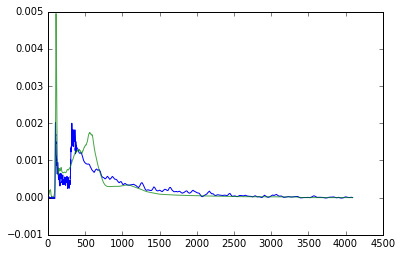

(1, 4096)
1/1 [==============================] - 0s 54ms/step
[[3.6338877e-04 2.8343446e-04 2.1854922e-04 ... 4.3439663e-08
  7.7549245e-08 1.1233549e-07]]


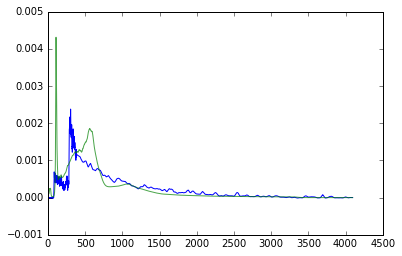

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[2.8014980e-04 2.1681428e-04 1.6580195e-04 ... 4.3070468e-08
  7.6920365e-08 1.1144622e-07]]


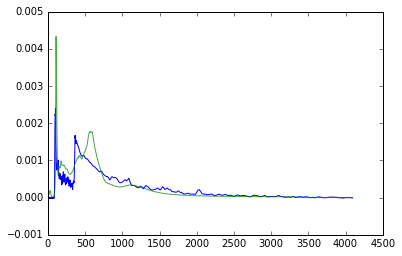

(1, 4096)
1/1 [==============================] - 0s 25ms/step
[[3.0576755e-04 2.3674607e-04 1.8110768e-04 ... 4.3156316e-08
  7.7067810e-08 1.1165282e-07]]


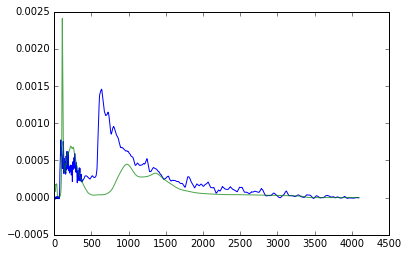

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[2.54325103e-04 1.96169931e-04 1.49641797e-04 ... 4.24830269e-08
  7.59174199e-08 1.10039885e-07]]


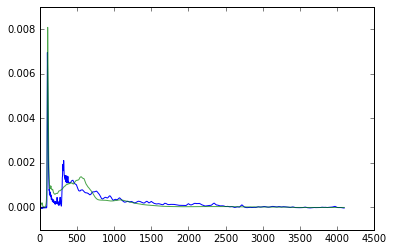

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[2.9983238e-04 2.3224023e-04 1.7773022e-04 ... 4.2799570e-08
  7.6460331e-08 1.1080124e-07]]


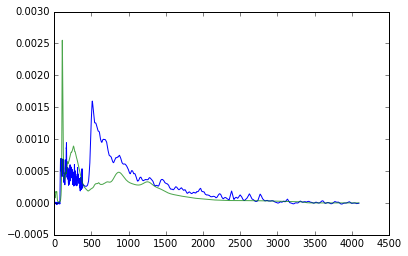

(1, 4096)
1/1 [==============================] - 0s 32ms/step
[[2.93000223e-04 2.26553791e-04 1.73057662e-04 ... 4.40034711e-08
  7.85226604e-08 1.13715515e-07]]


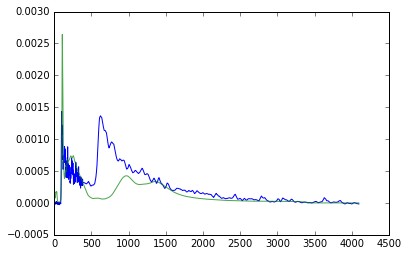

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[3.45180975e-04 2.67521071e-04 2.05245509e-04 ... 4.29351346e-08
  7.66902275e-08 1.11129296e-07]]


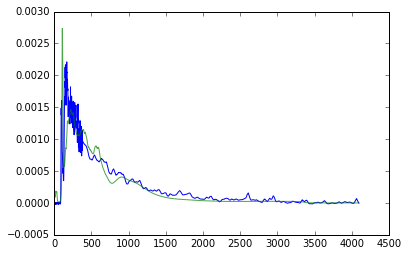

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[3.0542520e-04 2.3600549e-04 1.8035153e-04 ... 4.1465910e-08
  7.4151018e-08 1.0753635e-07]]


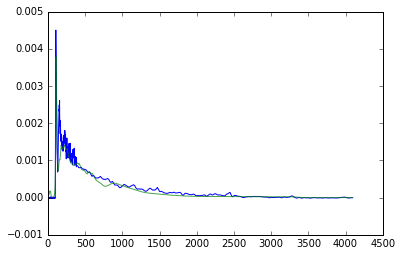

(1, 4096)
1/1 [==============================] - 0s 28ms/step
[[4.0622713e-04 3.1753693e-04 2.4535312e-04 ... 4.1199531e-08
  7.3693492e-08 1.0688180e-07]]


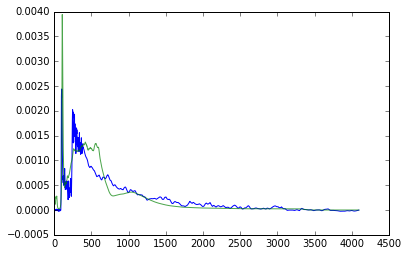

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[2.92930985e-04 2.26377815e-04 1.72797474e-04 ... 4.45870114e-08
  7.95358943e-08 1.15149824e-07]]


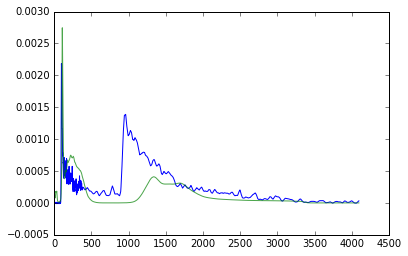

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[4.1003255e-04 3.1964728e-04 2.4676096e-04 ... 4.2283592e-08
  7.5563776e-08 1.0952207e-07]]


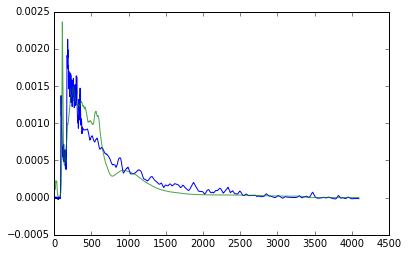

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[3.6286926e-04 2.8159155e-04 2.1639565e-04 ... 4.1818005e-08
  7.4760820e-08 1.0839878e-07]]


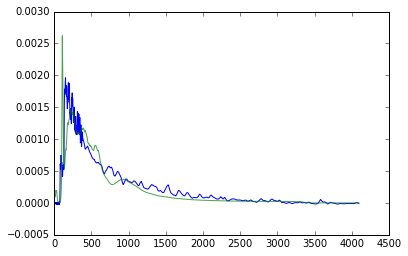

(1, 4096)
1/1 [==============================] - 0s 26ms/step
[[3.5492293e-04 2.7676651e-04 2.1333051e-04 ... 4.3639140e-08
  7.7899557e-08 1.1283973e-07]]


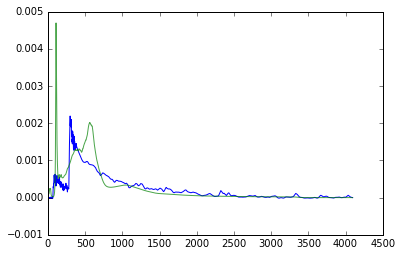

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[2.98197177e-04 2.30803154e-04 1.76526024e-04 ... 4.22442596e-08
  7.54970770e-08 1.09440215e-07]]


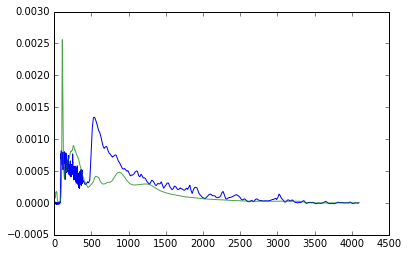

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[4.1557281e-04 3.2495899e-04 2.5129222e-04 ... 4.4785001e-08
  7.9881154e-08 1.1563181e-07]]


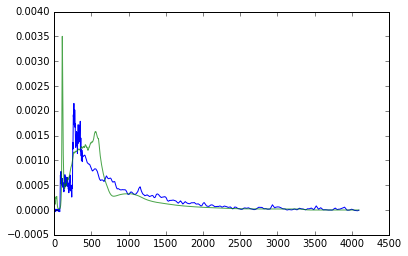

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[2.9579745e-04 2.2900198e-04 1.7514068e-04 ... 4.5271015e-08
  8.0719552e-08 1.1680610e-07]]


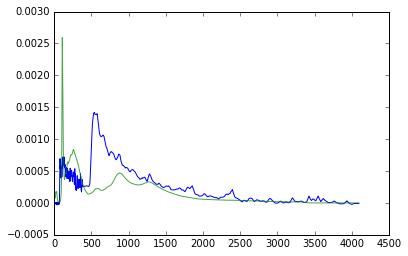

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[3.2327804e-04 2.5005348e-04 1.9141981e-04 ... 4.1681915e-08
  7.4525062e-08 1.0804911e-07]]


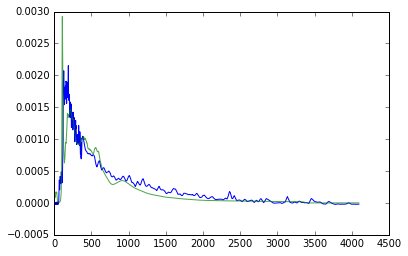

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[3.2388145e-04 2.5069728e-04 1.9194471e-04 ... 4.3463618e-08
  7.7605179e-08 1.1241759e-07]]


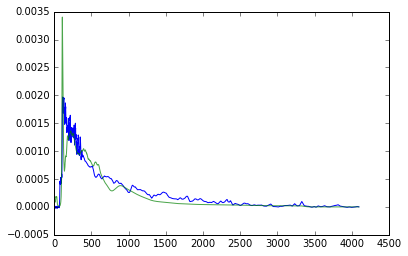

(1, 4096)
1/1 [==============================] - 0s 27ms/step
[[4.23851627e-04 3.30506387e-04 2.55374558e-04 ... 4.18814636e-08
  7.48701297e-08 1.08547546e-07]]


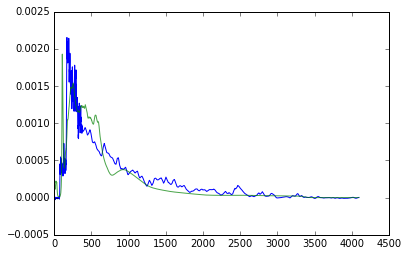

In [7]:
for i in range(20):
    X1 = next(single_gen(0))
    print(X1.shape)
    X2 = China.predict(X1,verbose=1)
    print(X2)
    plt.figure()
    plt.plot(X1[0],alpha=1)
    plt.plot(X2[0],alpha=0.7)
    plt.show()
    

In [10]:
classes = 2

def standard(x,height,decay):
    y = height*np.exp(-x*decay)
    return y

def shifter(x,starts):
    L = int(starts*len(x))
    y = np.zeros(len(x))
    y[:L] = np.zeros(L) 
    y[L:] = x[:(len(x)-L)]
    return y

def comb_standard(x,second,height_1,decay_1,height_2,decay_2):
    L = int(second*len(x))
    y = np.zeros(len(x))
    y[:L] = standard(x[:L],height_1,decay_1)
    y[L:] = standard(x[:(len(x)-L)],height_2,decay_2)
    return y

def noiser(x,strength):
    y = x + np.random.normal(0,strength,len(x))
    return y

def noiser_long(x,strength):
    noise = np.random.normal(0,strength,len(x))
    y = x + np.cumsum(noise)*strength
    return y

def noiser_comb(x,sepfact,strength):
    L = int(sepfact*len(x))
    x[:L] = noiser(x[:L],strength)
    x[L:] = noiser_long(x[L:],strength)
    return x

def array_maker(entries):
    x = np.arange(0,1,1/4096)
    x = np.expand_dims(x,axis=0)
    x = np.tile(x,[entries,1])
    return x

def double(x,second,height_1,decay_1,height_2,decay_2,starts,sepfact=0.15,strength=0.02):
    y = comb_standard(x,second,height_1,decay_1,height_2,decay_2)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def single(x,height,decay,starts,sepfact=0.15,strength=0.02):
    y = standard(x,height,decay)
    y = shifter(y,starts)
    y = noiser_comb(y,sepfact,strength)
    return y

def event_creators_single(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(5,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_2(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(10,2)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_single_3(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.1)
        r = np.random.normal(4,1)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)
    return x

def event_creators_sharp(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(1,0.01)
        r = np.random.normal(100,20)
        s = np.random.normal(0.03,0.005)
        x[i] = single(x[i],w,r,s)    
    return x

def event_creators_double_equal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.01)
        q = np.random.normal(5,2)
        r = np.random.normal(1,0.01)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x
    
def event_creators_double_unequal(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.2,0.01)
        p = np.random.normal(1,0.2)
        q = np.random.normal(50,10)
        r = np.random.normal(1,0.2)
        s = np.random.normal(50,10)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def event_creators_sharp_fat(entries):
    x = array_maker(entries)
    for i in range(entries):
        w = np.random.normal(0.015,0.001)
        p = np.random.normal(1,0.2)
        q = np.random.normal(100,20)
        r = np.random.normal(0.2,0.05)
        s = np.random.normal(5,2)
        t = np.random.normal(0.03,0.005)
        x[i] = double(x[i],w,p,q,r,s,t)
    return x

def comb(one,two,three,four,five,six,seven,eight,nine,ten,portion):
    one1,one2 = sep(one,1,portion)
    two1,two2 = sep(two,1,portion)
    three1,three2 = sep(three,1,portion)
    four1,four2 = sep(four,1,portion)
    five1,five2 = sep(five,1,portion)
    six1,six2 = sep(six,0,portion)
    seven1,seven2 = sep(seven,0,portion)
    eight1,eight2 = sep(eight,0,portion)
    nine1,nine2 = sep(nine,0,portion)
    ten1,ten2 = sep(ten,0,portion)

    z = np.concatenate((one1,two1,three1,four1,five1,six1,seven1,eight1,nine1,ten1),axis=0)
    y = np.concatenate((one2,two2,three2,four2,five2,six2,seven2,eight2,nine2,ten2),axis=0)
    return z, y

def generator(x):
    while 1:
        alpha = pmtall_pedestal("Alpha.root")
#         bad1 = pmtall_pedestal("BAD_DATA_QUALITY_1.root")
#         bad2 = pmtall_pedestal("BAD_DATA_QUALITY_2.root")
        piled = pmtall_pedestal("Piled_2.root")
        ls = pmtall_pedestal("LS.root")
        lsbeta = pmtall_pedestal("lsbeta.root")
        ref = pmtall_pedestal("RefPulse009.root")
        
        fake_beta = event_creators_single(4000)
        fake_ls = event_creators_sharp(4000)
        fake_dp_e = event_creators_double_equal(4000)
        fake_dp_ue = event_creators_double_unequal(4000)
        fake_lsbeta = event_creators_sharp_fat(4000)
        
        z1, z2 = comb(piled,ref,alpha,ls,lsbeta,fake_beta,fake_ls,fake_dp_e,fake_dp_ue,fake_lsbeta,x)
        s = np.random.permutation(np.arange(len(z2)))
        z1 = z1[s]
        z2 = z2[s]
#         print(len(z1))
#         para_piled = parameters("Piled_2.root")
#         para_ref = parameters("RefPulse009.root")
#         para_alpha = parameters("Alpha.root")
#         para_ls = parameters("LS.root")
#         para_lsbeta = parameters("lsbeta.root")
        
#         z3, z4 = comb5(para_piled,para_ref,para_alpha,para_ls,para_lsbeta,x)        
#         z3 = z3[s] 
#         z4 = z4[s]

        gasf = GASF(image_size=128, overlapping=False, scale='-1')
        
        for i in range(len(z2)):
            d1 = np.expand_dims(z1[i],axis=0)
            q = keras.utils.to_categorical(z2[i],classes)
            r = normalize(d1,norm="l1")
            s = np.expand_dims(q,axis=0)
            yield r,s
            
train_gen = generator(0)
val_gen = generator(1)
test_gen = generator(2)

steps_t = 35430
steps_vt = 5057
gan.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics=['accuracy'])
gan.fit_generator(train_gen,steps_per_epoch=steps_t, epochs=5, verbose=1, validation_data=val_gen,validation_steps=steps_vt)
gan.save("gan.h5")

Epoch 1/5
35430/35430 [==============================] - 2438s 69ms/step - loss: 6.3345 - acc: 0.6048 - val_loss: 6.3240 - val_acc: 0.6055
Epoch 2/5
35430/35430 [==============================] - 2356s 67ms/step - loss: 6.3343 - acc: 0.6049 - val_loss: 6.3240 - val_acc: 0.6055
Epoch 3/5
35430/35430 [==============================] - 2369s 67ms/step - loss: 6.3343 - acc: 0.6049 - val_loss: 6.3145 - val_acc: 0.6061
Epoch 4/5
30564/35430 [========================>.....] - ETA: 5:12 - loss: 6.3643 - acc: 0.6030

KeyboardInterrupt: 

In [7]:
predicted = gan.predict_generator(generator(0),max_queue_size=100,steps=2000,verbose=1)

2000/2000 [==============================] - 52s 26ms/step


array([[0.99836427, 0.00150627],
       [0.99836427, 0.00150627],
       [0.99836427, 0.00150627],
       ...,
       [0.99836427, 0.00150627],
       [0.99836427, 0.00150627],
       [0.99836427, 0.00150627]], dtype=float32)

In [11]:
gan.save("gan.h5")